In [36]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC Dataset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [37]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


sys.path.insert(0, "../")
# import utils.utils_feature_selection as fs
# import utils.utils_evaluation as e
# import utils.utils_figures as f
import utils.settings as s
# import utils.utils_processing as pp

s.init()
seed = s.seed
pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]

<Figure size 2000x1000 with 0 Axes>

In [38]:
data = pd.read_excel(f"../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx")
#df_candidates = pd.read_excel("..//input_survey_data/input_data_businessreduction_tueb.xlsx")

print(data.shape)
data.tail(2)

(324, 24)


,Target_relative_contentloss_euro,Target_relative_contentloss_euro.1,shp_registered_capital_euro,flowvelocity,shp_employees,shp_avgmonthly_sale_cat,bage,water_barriers_impl,b_area,pumping_equipment_impl,water_depth_cm,hh_monthly_income_cat,inundation_duration_h,resistant_material_building_impl,flood_experience,emergency_measures.2,protect_valuables_impl,elevation_building_impl,shp_sector,emergency_measures.4,contaminations.0,emergency_measures.7,shp_owner,electricity_higher_impl
322,0.0,0.0,3682.6,2,2,2,1.0,1,80.0,5,40,3.0,5.0,5,6,1,1,4,11,1,0,1,3,5
323,0.0,0.0,3682.6,3,2,3,30.0,1,60.0,1,60,4.0,4.0,5,6,1,2,2,11,1,0,1,1,1


In [39]:
data = data.drop("Target_relative_contentloss_euro.1", axis = 1)
data = data.drop("bage", axis = 1) # drop, due to high negative correlation to b_area / hh_monthly _income / hp_avgmonthly_sale

In [40]:
## TEST before using weights from Log Reg, 

data = data.loc[data[f"{target}"]>0, :]


In [41]:
# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f'bn_{target}'

# Select the columns to use in the NPBN
columns_used=range(0, 11) # use currnetly 10 most important features + target for BN
data = data.iloc[:,columns_used] 

# Extract the variable names
names = list(data.columns)
names = {k: i for i, k in enumerate(set(names))}
print("Using following features:", names)

# shp_sector, emploees, reg_capital, avgmon_sale, mon_income
# flovelo, w_depth, contamam 0, inund_h
# flood_exp, emergy_2, water_bar_impl, pump_eq_impl, protect_valuabl_impl, resistant_m_b_impl, elec_higher_impl
# overall_building_problm, b_area, 

Using following features: {'flowvelocity': 0, 'shp_employees': 1, 'b_area': 2, 'water_barriers_impl': 3, 'water_depth_cm': 4, 'pumping_equipment_impl': 5, 'hh_monthly_income_cat': 6, 'inundation_duration_h': 7, 'shp_avgmonthly_sale_cat': 8, 'Target_relative_contentloss_euro': 9, 'shp_registered_capital_euro': 10}


In [42]:
# Extract number of nodes from data
N = data.shape[1]  # number of nodes == number of features + target

# Defining the structure of the BN
parent_cell = [None]*N


parent_cell[0] = [names["water_depth_cm"], names["inundation_duration_h"]]              #   flowvelo (parent nodes: water_depth_cm) 
parent_cell[1] = [names["shp_avgmonthly_sale_cat"]]                                     #   shp_employees (parent node: shp_avgmonthly_sale_cat)   
parent_cell[2] = [names["shp_registered_capital_euro"]]                                 #   b_area (parent nodes: shp_registered_capital_euro)
parent_cell[3] = [names["shp_registered_capital_euro"], names["water_depth_cm"]]        #   water_barriers_impl   (parent: shp_registered_capital_euro) or dependence on water_depth ?
parent_cell[4] = []                                                                     #   water_depth_cm 
parent_cell[5] = [names["shp_avgmonthly_sale_cat"]] # , names["water_depth_cm"]]        #   pumping_equipment_impl  (parent:  shp_registered_capital_euro) or dependence on water_depth ?
parent_cell[6] =  [names["shp_avgmonthly_sale_cat"]]                                    #   hh_monthly_income_cat (parent node: shp_avgmonthly_sale_cat)   
parent_cell[7] = []                                                                     #   inundation_duration_h
parent_cell[8] = [names["shp_registered_capital_euro"]]                                 #   shp_avgmonthly_sale_cat (parent node: shp_registered_capital_euro)
parent_cell[9] = [0,1,2,3,4,5,6,7,8,10]                                                 #   target (parents: all other features)
parent_cell[10] = []                                                                    #   shp_registered_capital_euro  

In [43]:
parent_cell

[[4, 7],
 [8],
 [10],
 [10, 4],
 [],
 [8],
 [8],
 [],
 [10],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10],
 []]

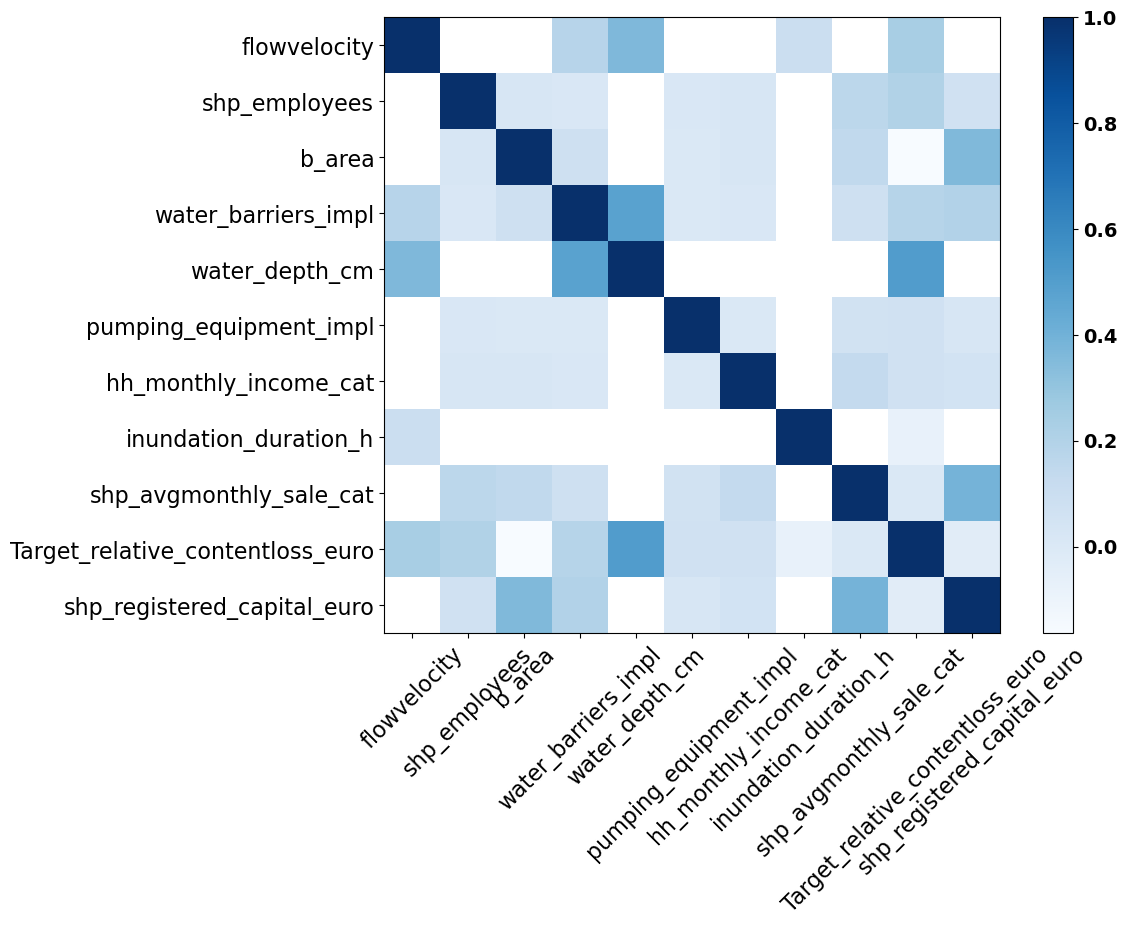

In [44]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

R = bn_rankcorr(parent_cell,        # structure of the BN
                data,               # matrix of data
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.


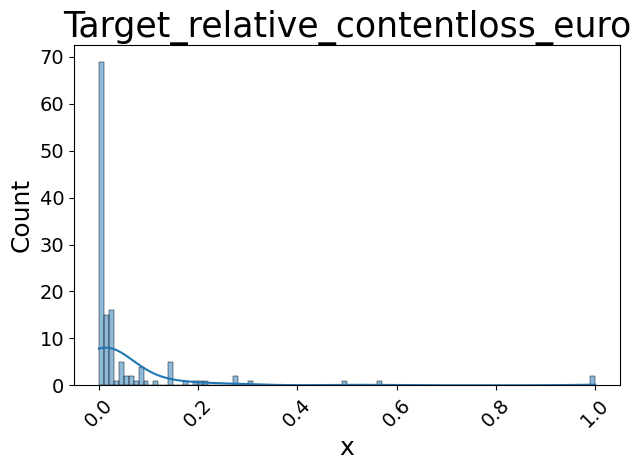

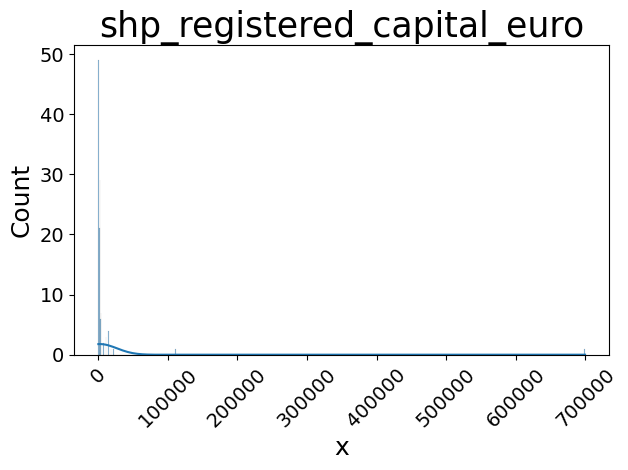

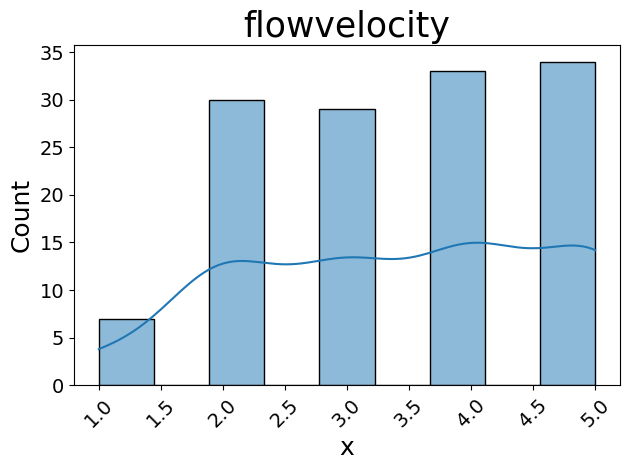

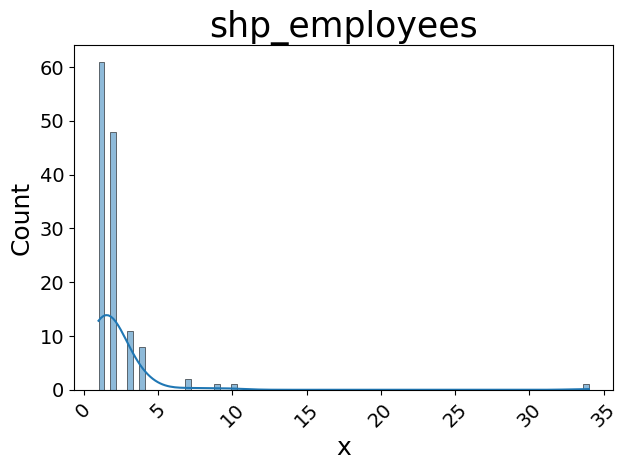

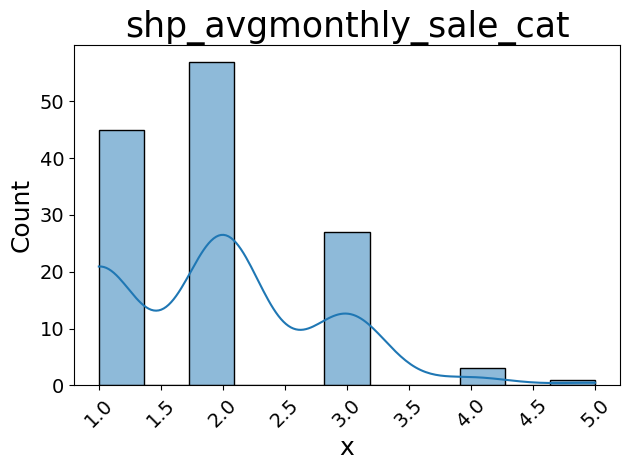

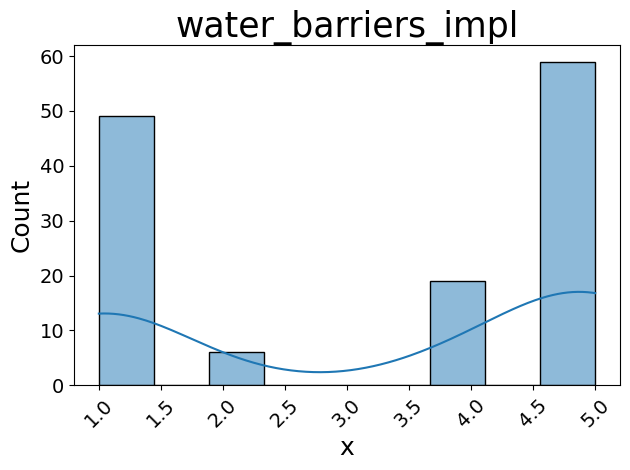

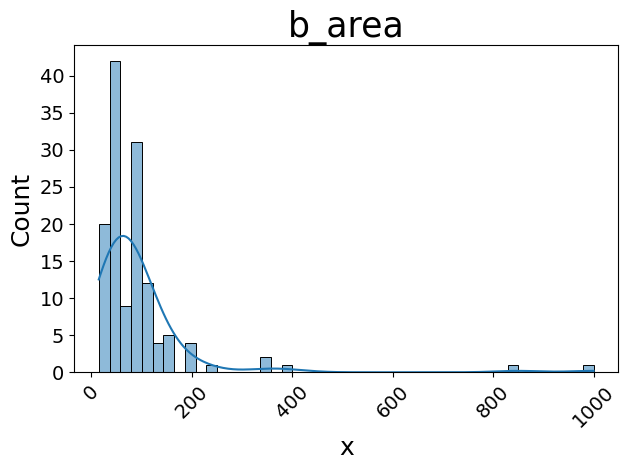

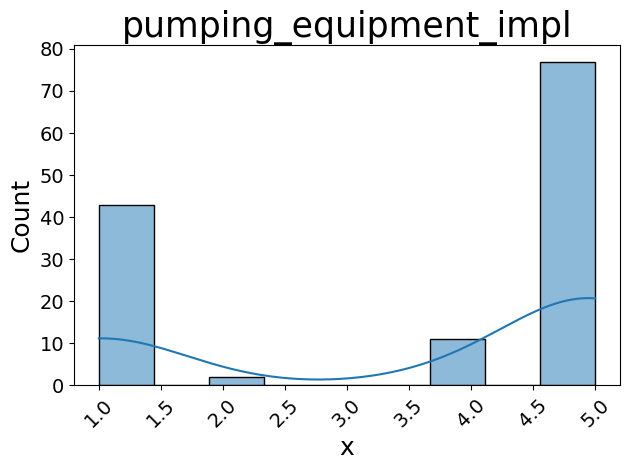

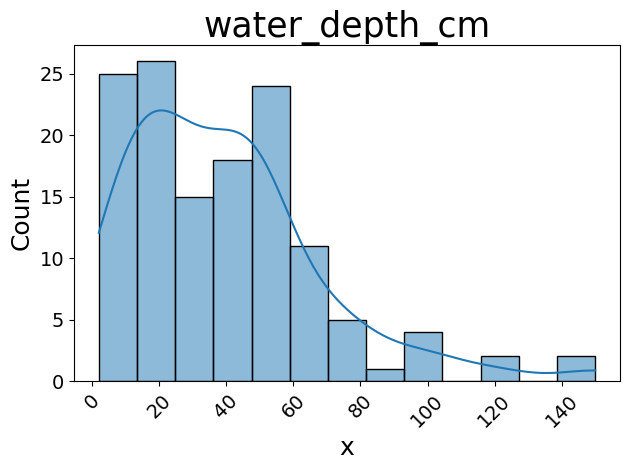

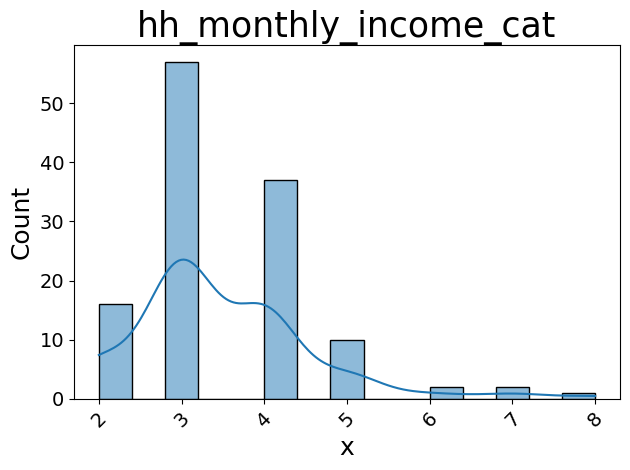

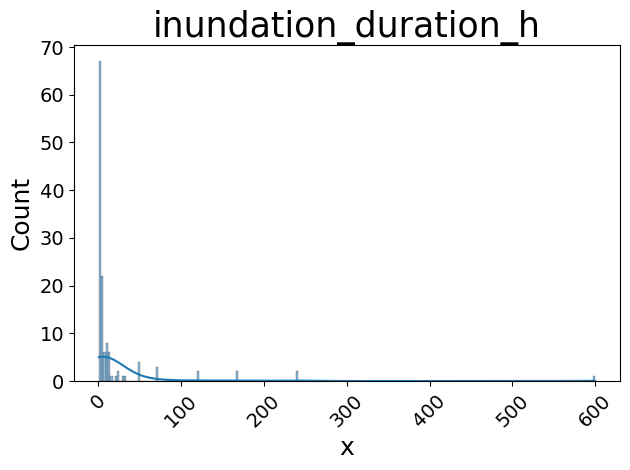

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\models\\BN_visualize_bn_Target_relative_contentloss_euro_margins.pdf'

In [45]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             data.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             data.columns,                      # names of variables
             data = data,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


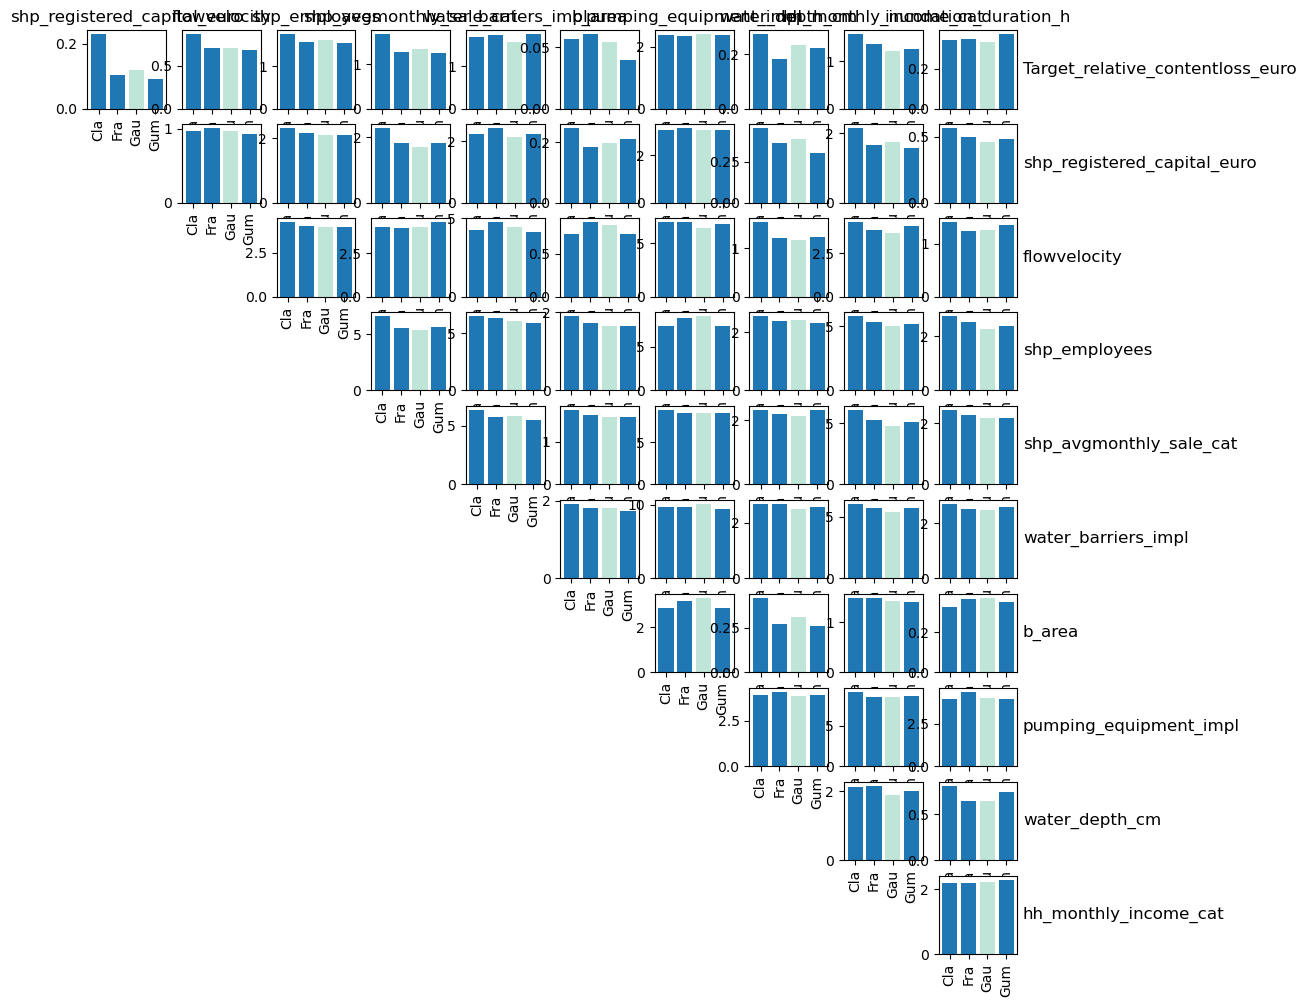

In [46]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(data,                   # DataFrame with data
                  names = data.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


In [ ]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() -> ~ np.matmul() in d_cal.py inside pybanshee package

# D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
#                             R,        # the rank correlation matrix 
#                             data,     # DataFrame with data
#                             4000,     # number of samples drawn d-Cal(ERC,NRC)
#                             400,      # number of samples drawn d-Cal(NRC,BNRC)
#                             1000,     # number of iterations to compute CI
#                             Plot=True,          # create a plot (0=don't create plot)
#                             Type='H',           # take Hellinger distance (default)
#                             fig_name=fig_name)  # figure name
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large datasets.


In [29]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[0,1,2,3] #conditionalized variables, all except for safety (predict)
values = data.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              data,             # DataFrame with data
              Output='mean')    # type of output data


# Evaluation
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_original=data.iloc[:,4].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_original - y_original.mean(axis=0))/y_original.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate mean absolute error
MAE = np.mean(np.abs(y_pred-y_original))

# Calculate mean bias error
MBE = np.mean(y_pred-y_original)

# Calculate root mean square error
RMSE = (np.mean((y_pred-y_original)**2))**(1/2)

# The coefficient of determination between modelled and observed safety in 
# US cities is rather low (0.21), but the average error equals only around
# a quarter of the average value of safety, and there is almost no bias.
# However, for proper validation, if sufficient data is available, a split-
# -sample validation or a k-fold cross-validation should be performed.

ValueError: A value (0.9993846343929772) in x_new is above the interpolation range's maximum value (0.9938650306748467).